In [1]:
%pylab inline
%matplotlib inline

import os
os.chdir("/Users/Bya/git/predictEPL/MyFunctions/")
from dataIO import GetFilenames, csv_dic_df
from converter import toSeconds

import time
import pandas as pd
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


### Preprocessing Function

In [2]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import replacers

def cleanHash(word):
    if word[0] == '#':
        return word[1::]
    elif word[0] == '@':
        return '@'
    elif word[0:4] == 'http':
        return 'http'
    else:
        return word

def preprocessing_tweet(tweet, debug = False):
    if debug:
        print("====================================")
        print("[Original Tweet]: \n\n %s \n\n" % tweet)


    # can't -> cannot, bya's -> bya is
    replacer = replacers.RegexpReplacer()
    tweet = replacer.replace(tweet)
    if debug:
        print("====================================")
        print("[Replaced Tweet]: \n\n %s \n\n" % tweet)


    # Tweet tokenizer and lower case
    words = TweetTokenizer().tokenize(tweet)
    words = [word.lower() for word in words]
    if debug:
        print("====================================")
        print("[Tokenized Tweet]: \n\n %s \n\n" % words)


    # defining stopwords
    english_stops = set(stopwords.words('english'))
    english_stops_added = english_stops | {'!', '.', ',', ':', ';', '#', '?', 'RT', '-', '@', 'rt'}
    words = [word for word in words if word not in english_stops_added]
    if debug:
        print("====================================")
        print("[Cleaned Stopwords Tweet]: \n\n %s \n\n" % words)



    # words = map(lambda word: cleanHash(word), words)
    words = [cleanHash(word) for word in words]
    if debug:
        print("====================================")
        print("[Clean hash Tweet]: \n\n %s \n\n" % words)



    # Stemmer
    stemmer = PorterStemmer()
    words_stemmed = list(map(lambda word: stemmer.stem(word), words))
    if debug:
        print("====================================")
        print("[Stemmed hash Tweet]: \n\n %s \n\n" % words_stemmed)



    # Cleaning not useful Tweets
    # ex: Watch Live Stream
    pattern1 = ["watch", "live", "stream"]
    good_tweet = True
    if pattern1[0] in words and pattern1[1] in words and pattern1[2] in words:
        good_tweet = False
        if debug:
            print("====================================")
            print("[Not good Tweet!]: \n\n detected: \n\n %s" % pattern1)
    
    return words, words_stemmed, good_tweet

### Read NRC Emotion-Lexicon and create dictionary

In [3]:
# read Emotion-Lexicon.txt
pathData = "/Users/Bya/Dropbox/Research/resources/NRC-Emotion-Lexicon-v0.92/"
os.chdir(pathData)
with open("Emotion-Lexicon.txt", 'r') as emoleRaw:
        emoleRaw = emoleRaw.readlines()


# create dic
dic_emolex = {}
dic_emolex_stemmed = {}

for line in emoleRaw:
    word, category, flag = line.split()
    flag = int(flag)
    
    if word not in dic_emolex:
        dic_emolex[word] = {}
        dic_emolex_stemmed[PorterStemmer().stem(word)] = {}
    
    dic_emolex[word][category] = flag
    dic_emolex_stemmed[PorterStemmer().stem(word)][category] = flag
    dic_emolex_stemmed[PorterStemmer().stem(word)]["_original_word"] = word

print("All Words: %s" % len(dic_emolex.keys()))

All Words: 14182


### Tweet's Emotion-Lexicon count

In [4]:
# sum of all words emotion-lexicon

def tweet_emolex(words, words_stemmed, good_tweet, debug = False):
    
    dic_tweet_emolex = {
        'anger': 0,
        'fear': 0,
        'disgust': 0,
        'sadness': 0,
        'surprise': 0,
        'trust': 0,
        'joy': 0,
        'anticipation': 0,
        'positive': 0,
        'negative': 0,
    }
    
    if not good_tweet:
        return dic_tweet_emolex


    for i in range(len(words)):
        # search word on non-stemmed dictionary
        if words[i] in dic_emolex:
            if debug:
                print("w->d")
                print(words[i])
                print(dic_emolex[words[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex[words[i]][key]
        
        # search stemmed word on non-stemmed dictionary
        elif words_stemmed[i] in dic_emolex:
            if debug:
                print("sw->d")
                print(words[i])
                print(words_stemmed[i])
                print(dic_emolex[words_stemmed[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex[words_stemmed[i]][key]

        # search stemmed word on stemmed dictionary
        elif words_stemmed[i] in dic_emolex_stemmed:
            if debug:
                print("sw->sd")
                print(words[i])
                print(words_stemmed[i])
                print(dic_emolex_stemmed[words_stemmed[i]])

            for key in dic_tweet_emolex.keys():
                dic_tweet_emolex[key] += dic_emolex_stemmed[words_stemmed[i]][key]

    return dic_tweet_emolex

### Plot Emotion-Lexion

In [5]:
def create_minute_dics_emolex(df, side, category, cumulative = False):
    minutes = range(120) 
    dic_minutes = {}

    for minute in minutes:    
        try:
            if cumulative:
                dic_minutes[minute] = sum(df[(df['side'] == side) & \
                                                    (df['ith_minute'] < minute + 1)][category])
            else:
                dic_minutes[minute] = sum(df[(df['side'] == side) & \
                                                    (df['ith_minute'] > minute) & \
                                                    (df['ith_minute'] < minute + 1)][category])
        except:
            dic_minutes[minute] = 0
        
    return (dic_minutes)


def plot_emolex(home_team, list_dic_minutes, colors, categorys, i_plot,limit=True):

    ax = plt.subplot(3,2,i_plot)
    if limit:
        ax.set_xlim([0, 60])
    else:
        ax.set_xlim([0, 120])

    for i in range(len(list_dic_minutes)):
        tweets = tuple(list(list_dic_minutes[i].values()))
        plot1 = plt.plot(tweets, label=categorys[i], alpha=0.5, color=colors[i])

    
    plt.xlabel('Minutes')
    plt.ylabel('Emotion Signals')
    plt.title('Emotion-Lexicon  (Home Team: %s)'  % home_team)
    plt.legend()
    plt.tight_layout()


def plot_three(df, home_team, away_team):
    side = ['home', 'away', 'both']
    categorys_neg = ['anger', 'fear', 'disgust', 'sadness', 'surprise']
    colors_neg = ['red', 'darkorange', 'darksalmon', 'palegreen', 'darkgreen']
    categorys_pos = ['trust', 'joy', 'anticipation']
    colors_pos = ['skyblue', 'purple', 'blue']
    list_dic_minutes = []
    categorys_sent = ['positive', 'negative']
    colors_sent = ['green', 'red']

    plt.figure(figsize=(15, 20))

    list_dic_minutes = []
    for category in categorys_neg:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_neg, categorys_neg, 1, False)

    list_dic_minutes = []
    for category in categorys_pos:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_pos, categorys_pos, 3, False)


    list_dic_minutes = []
    for category in categorys_sent:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[0], category))
    plot_emolex(home_team, list_dic_minutes, colors_sent, categorys_sent, 5, False)

    
    list_dic_minutes = []
    for category in categorys_neg:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_neg, categorys_neg, 2, False)

    list_dic_minutes = []
    for category in categorys_pos:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_pos, categorys_pos, 4, False)


    list_dic_minutes = []
    for category in categorys_sent:
        list_dic_minutes.append(create_minute_dics_emolex(df, side[1], category))
    plot_emolex(away_team, list_dic_minutes, colors_sent, categorys_sent, 6, False)


    plt.show()

In [6]:
dic_results_10 = {
1:"""
1-0	(36)GIROUD OLIVIER
2-0	(38)KOSCIELNY LAURENT
2-1	BARKLEY ROSS(44)
2-1	No Scores
""",

2:"""
1-0	(1)RITCHIE MATT
1-1	KANE HARRY(Pen9)
1-2	DEMBELE MOUSA(17)
1-3	LAMELA ERIK(29)
1-4	KANE HARRY(56)
1-5	KANE HARRY(63)
""",

3:"""
0-0	No Scores
1-0	(59)VARDY JAMIE
""",

4:"""
0-0	No Scores
1-0	(77)BENTEKE CHRISTIAN
1-1	MANE SADIO(86)
""",

5:"""
0-0	No Scores
0-1	RONDON SALOMON(46)
""",

6:"""
0-1	DEENEY TROY(43)
0-2	ABDI ALMEN(69)
""",

7:"""
1-0	(Pen45+3)JOHNSON ADAM
2-0	(65)JONES BILLY
3-0	(86)FLETCHER STEVEN
""",

8:"""
0-0
0-0
""",

9:"""
0-0	No Scores
1-0	(62)AYEW JORDAN
1-1	SIGURDSSON GYLFI(68)
1-2	AYEW ANDRE(87)
""",

10:"""
1-0	(17)ZARATE MAURO
1-1	CAHILL GARY(56)
2-1	(79)CARROLL ANDY
"""
    }

### Reading Soccer Match datas and Create Emotion-Lexicon Dataframe

In [7]:
# read csv data as dataframe
def create_emolex_df(filePath):
    home_team = filePath.split("_")[0][5::]
    away_team = filePath.split("_")[2][0:-4]

    df = csv_dic_df(filePath)

    # adding minute column
    df['ith_minute'] = [float(ith_minute) for ith_minute in df['ith_minute']]

    # adding Emotion-Lexicon columns
    df['anger'] = 0
    df['fear'] = 0
    df['disgust'] = 0
    df['sadness'] = 0
    df['surprise'] = 0
    df['trust'] = 0
    df['joy'] = 0
    df['anticipation'] = 0
    df['positive'] = 0
    df['negative'] = 0


    # adding emotion-lexicon values to dataframe
    for i in range(len(df)):
        tweet = df.loc[i]['text']

        words, words_stemmed, good_tweet = preprocessing_tweet(tweet)
        dic_counted = tweet_emolex(words, words_stemmed, good_tweet)

        df.loc[i, 'anger'] = dic_counted['anger']
        df.loc[i, 'anticipation'] = dic_counted['anticipation']
        df.loc[i, 'disgust'] = dic_counted['disgust']
        df.loc[i, 'fear'] = dic_counted['fear']
        df.loc[i, 'joy'] = dic_counted['joy']
        df.loc[i, 'negative'] = dic_counted['negative']
        df.loc[i, 'positive'] = dic_counted['positive']
        df.loc[i, 'sadness'] = dic_counted['sadness']
        df.loc[i, 'surprise'] = dic_counted['surprise']
        df.loc[i, 'trust'] = dic_counted['trust']
    
    return df

### Counting Emotion and Sentiment

In [8]:
def calculate_df_emolex(df, side):
    dic = {
        'anger': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['anger'])],
        'fear': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['fear'])],
        'disgust': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['disgust'])],
        'sadness': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['sadness'])],
        'surprise': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['surprise'])],
        'trust': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['trust'])],
        'joy': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['joy'])],
        'anticipation': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['anticipation'])]
    }
    
    
    dic_sent = {
        'positive': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['positive'])],
        'negative': [sum(df[(df['side'] == side) & (df['ith_minute'] < 60)]['negative'])]
    }
    
    
    emolex_sum = float(sum(list(dic.values())))
    emolex_sum_sent = float(sum(list(dic_sent.values())))

    for key in dic.keys():
        dic[key].append(dic[key][0] / emolex_sum)
    
    for key in dic_sent.keys():
        dic_sent[key].append(dic_sent[key][0] / emolex_sum_sent)
    
    return dic, dic_sent

### Ploting and Calculating GW10

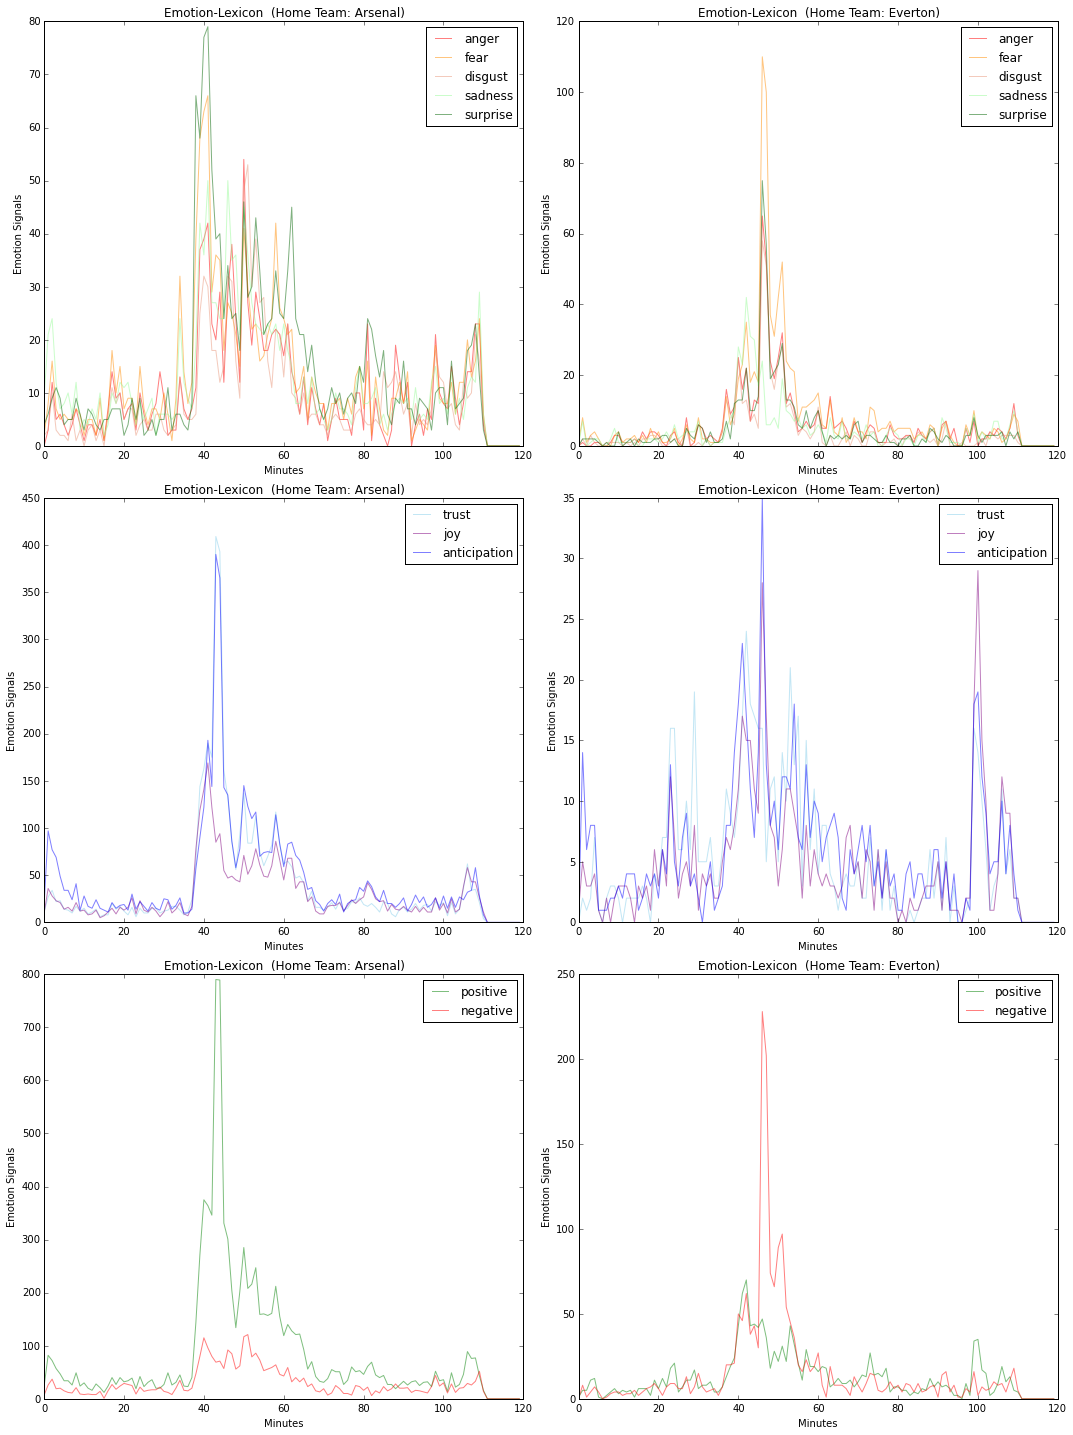


[Time]: 86.46077799797058

[Game]: Arsenal vs Everton

1-0	(36)GIROUD OLIVIER
2-0	(38)KOSCIELNY LAURENT
2-1	BARKLEY ROSS(44)
2-1	No Scores




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 4743 (0.23) 	 663 (0.12)
---------------------------------------------------
anticipation 		 5393 (0.26) 	 703 (0.13)
---------------------------------------------------
     sadness 		 1464 (0.07) 	 566 (0.11)
---------------------------------------------------
    surprise 		 1735 (0.08) 	 602 (0.11)
---------------------------------------------------
        fear 		 1543 (0.07) 	 1004 (0.19)
---------------------------------------------------
         joy 		 3505 (0.17) 	 579 (0.11)
---------------------------------------------------
       anger 		 1266 (0.06) 	 704 (0.13)
---------------------------------------------------
     disgust 		 1125 (0.05) 	 491 (0.09

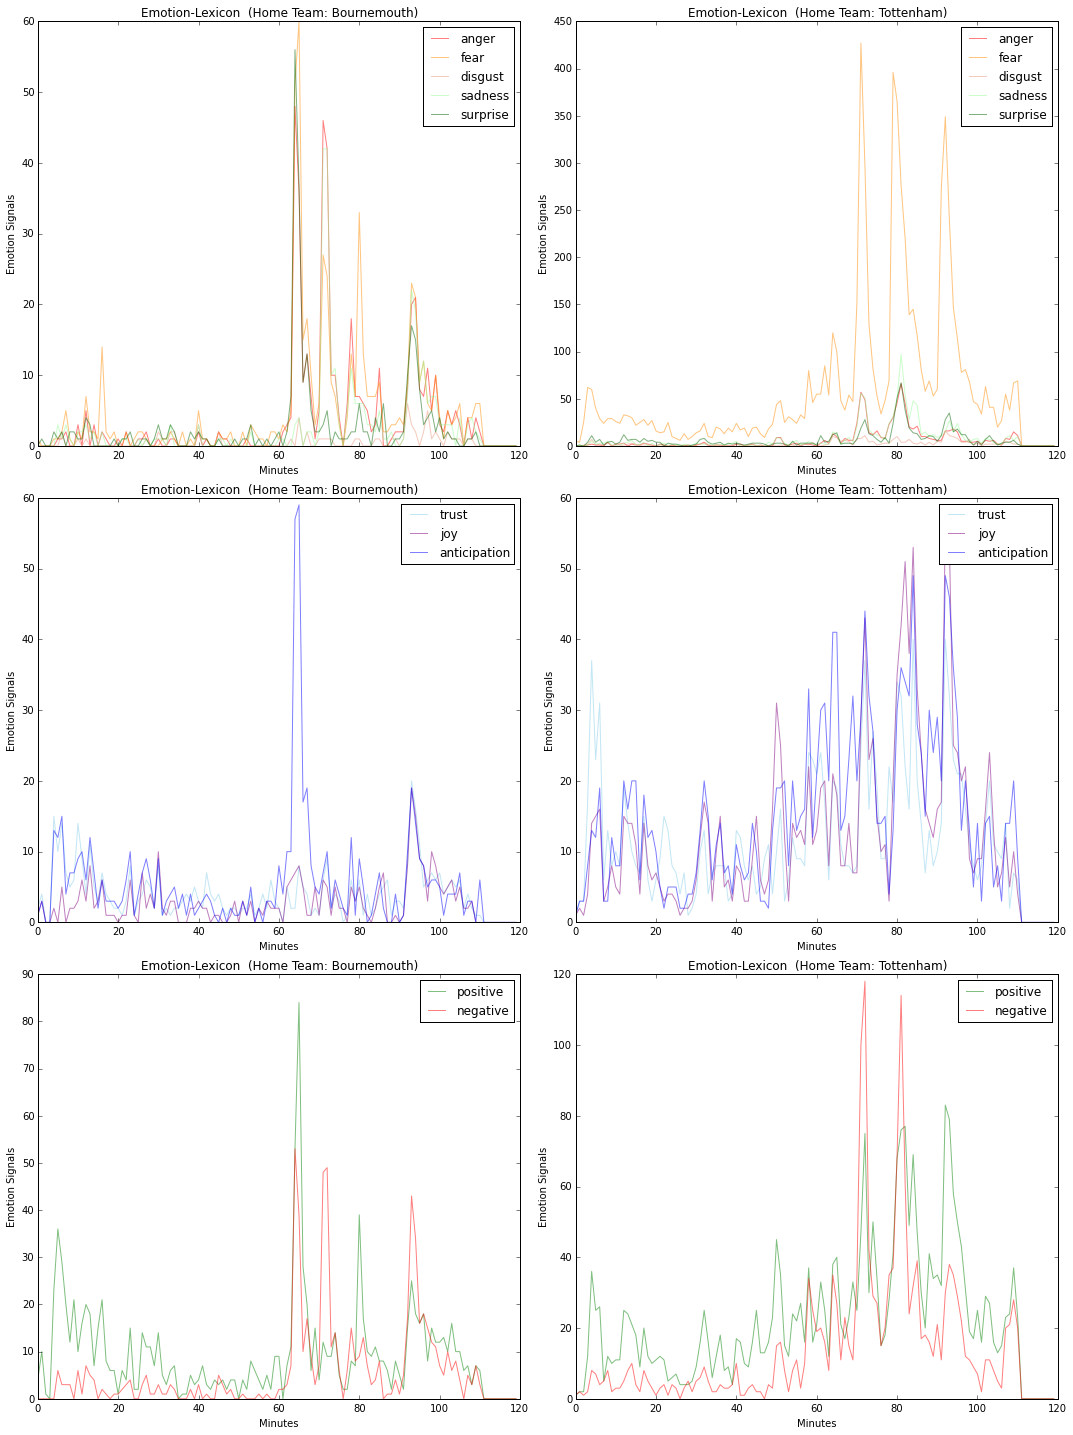


[Time]: 58.79548001289368

[Game]: Bournemouth vs Tottenham

1-0	(1)RITCHIE MATT
1-1	KANE HARRY(Pen9)
1-2	DEMBELE MOUSA(17)
1-3	LAMELA ERIK(29)
1-4	KANE HARRY(56)
1-5	KANE HARRY(63)




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 481 (0.15) 	 1441 (0.10)
---------------------------------------------------
anticipation 		 650 (0.20) 	 1809 (0.12)
---------------------------------------------------
     sadness 		 333 (0.10) 	 1007 (0.07)
---------------------------------------------------
    surprise 		 315 (0.10) 	 817 (0.05)
---------------------------------------------------
        fear 		 594 (0.18) 	 7370 (0.49)
---------------------------------------------------
         joy 		 340 (0.10) 	 1551 (0.10)
---------------------------------------------------
       anger 		 477 (0.15) 	 800 (0.05)
---------------------------------------------------

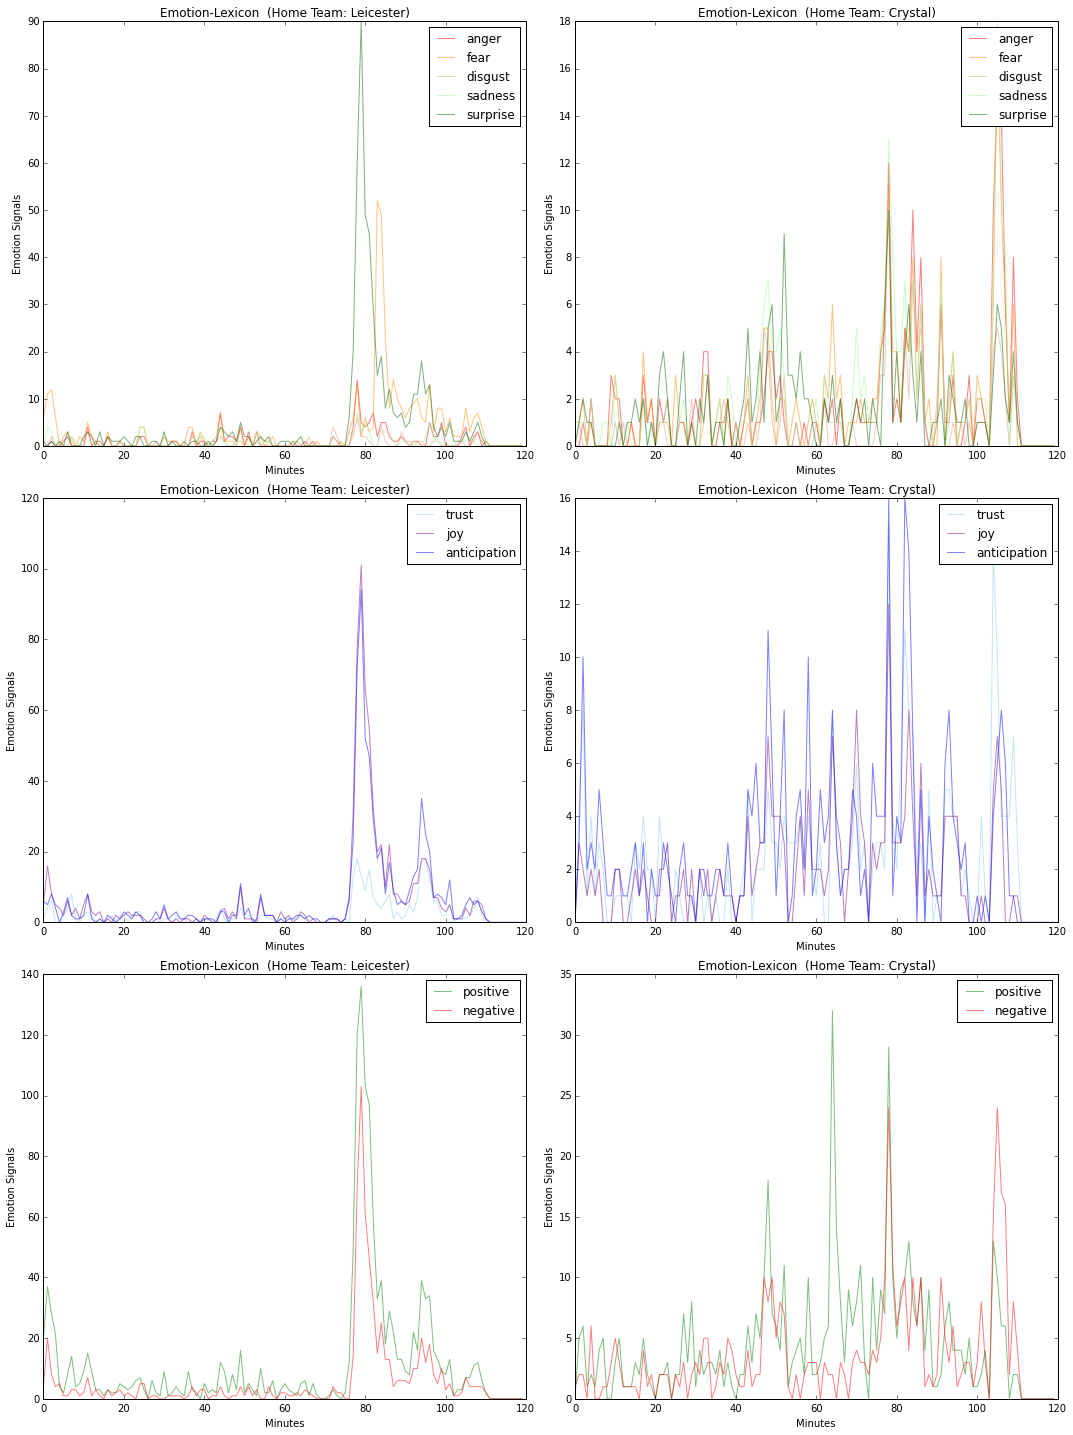


[Time]: 24.776063919067383

[Game]: Leicester vs Crystal

0-0	No Scores
1-0	(59)VARDY JAMIE




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 303 (0.10) 	 297 (0.16)
---------------------------------------------------
anticipation 		 757 (0.24) 	 342 (0.18)
---------------------------------------------------
     sadness 		 107 (0.03) 	 244 (0.13)
---------------------------------------------------
    surprise 		 559 (0.18) 	 194 (0.10)
---------------------------------------------------
        fear 		 441 (0.14) 	 226 (0.12)
---------------------------------------------------
         joy 		 774 (0.24) 	 241 (0.13)
---------------------------------------------------
       anger 		 147 (0.05) 	 217 (0.11)
---------------------------------------------------
     disgust 		 74 (0.02) 	 126 (0.07)



******[Sentiment]******
----------------------------

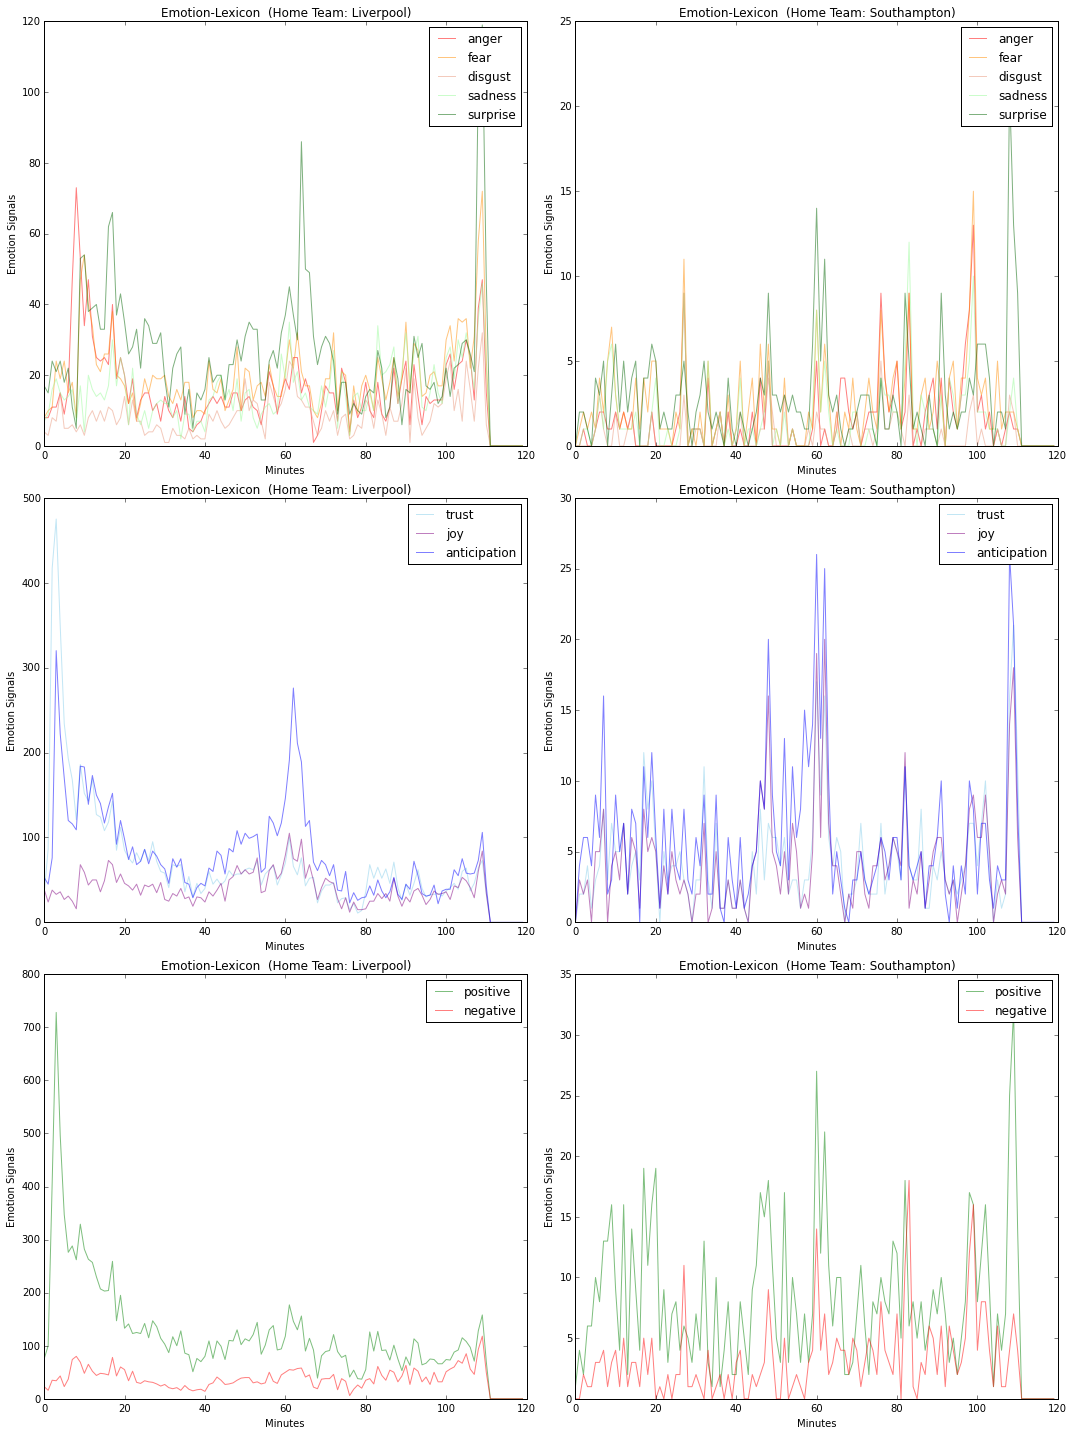


[Time]: 118.56556105613708

[Game]: Liverpool vs Southampton

0-0	No Scores
1-0	(77)BENTEKE CHRISTIAN
1-1	MANE SADIO(86)




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 8348 (0.26) 	 508 (0.18)
---------------------------------------------------
anticipation 		 9366 (0.29) 	 678 (0.25)
---------------------------------------------------
     sadness 		 1763 (0.05) 	 191 (0.07)
---------------------------------------------------
    surprise 		 3036 (0.09) 	 340 (0.12)
---------------------------------------------------
        fear 		 2282 (0.07) 	 285 (0.10)
---------------------------------------------------
         joy 		 4693 (0.15) 	 481 (0.18)
---------------------------------------------------
       anger 		 1871 (0.06) 	 185 (0.07)
---------------------------------------------------
     disgust 		 1001 (0.03) 	 78 (0.03)



******[Sentimen

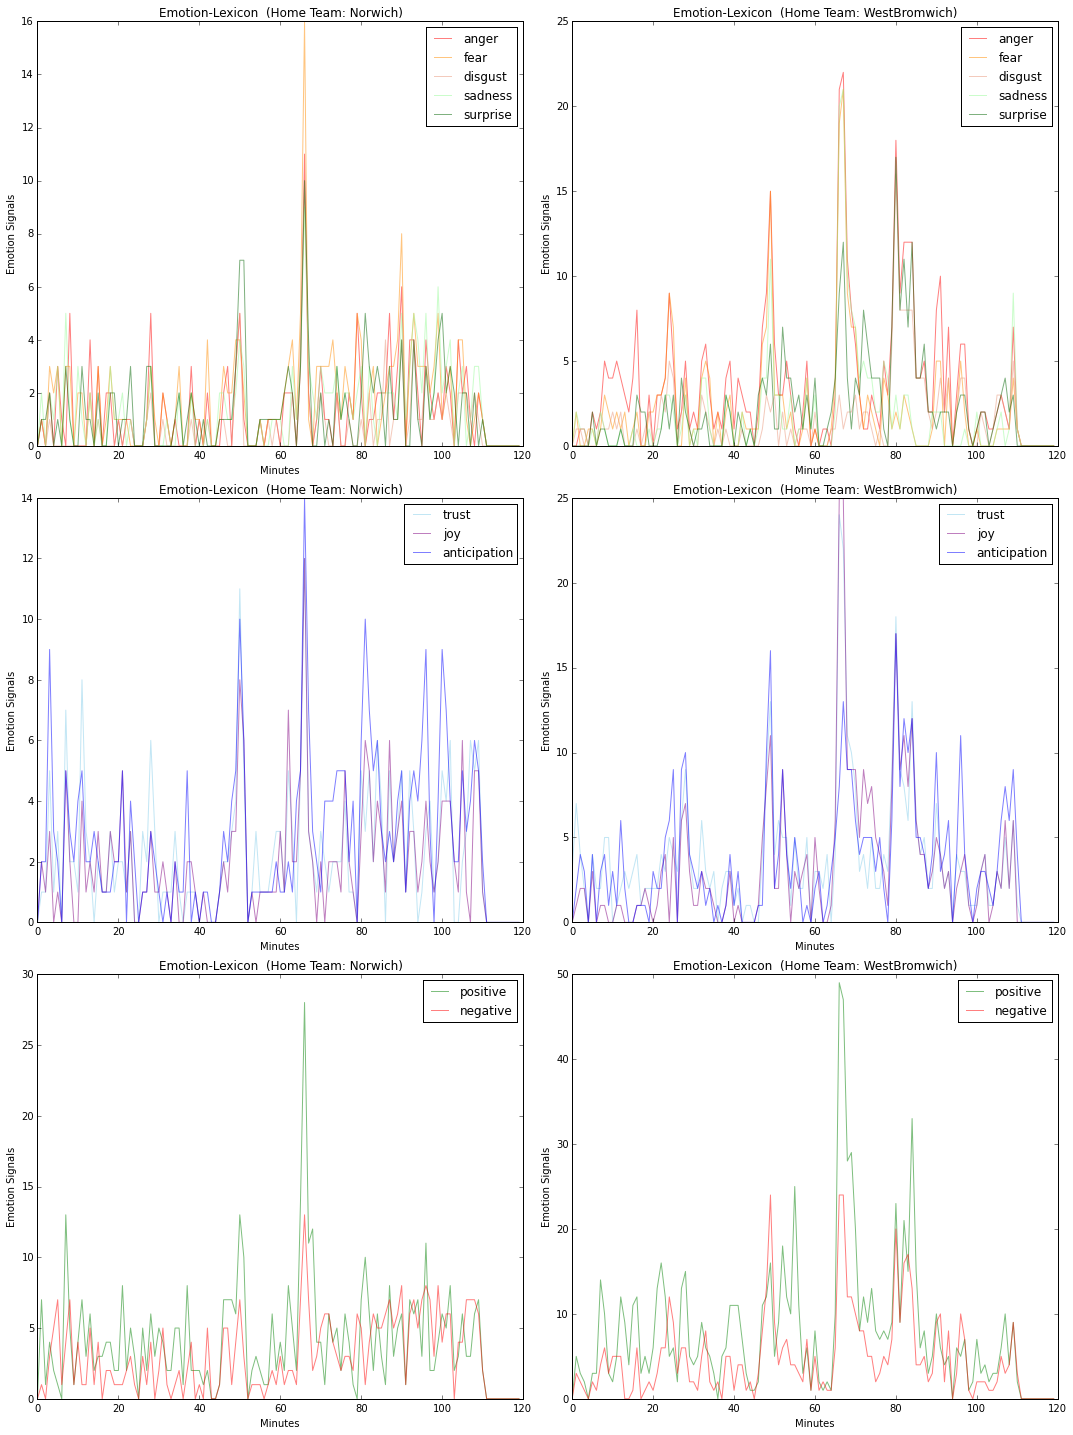


[Time]: 21.220494031906128

[Game]: Norwich vs WestBromwich

0-0	No Scores
0-1	RONDON SALOMON(46)




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 268 (0.16) 	 454 (0.17)
---------------------------------------------------
anticipation 		 337 (0.20) 	 436 (0.16)
---------------------------------------------------
     sadness 		 175 (0.11) 	 221 (0.08)
---------------------------------------------------
    surprise 		 162 (0.10) 	 277 (0.10)
---------------------------------------------------
        fear 		 214 (0.13) 	 262 (0.10)
---------------------------------------------------
         joy 		 237 (0.14) 	 396 (0.15)
---------------------------------------------------
       anger 		 163 (0.10) 	 436 (0.16)
---------------------------------------------------
     disgust 		 97 (0.06) 	 197 (0.07)



******[Sentiment]******
----------------------

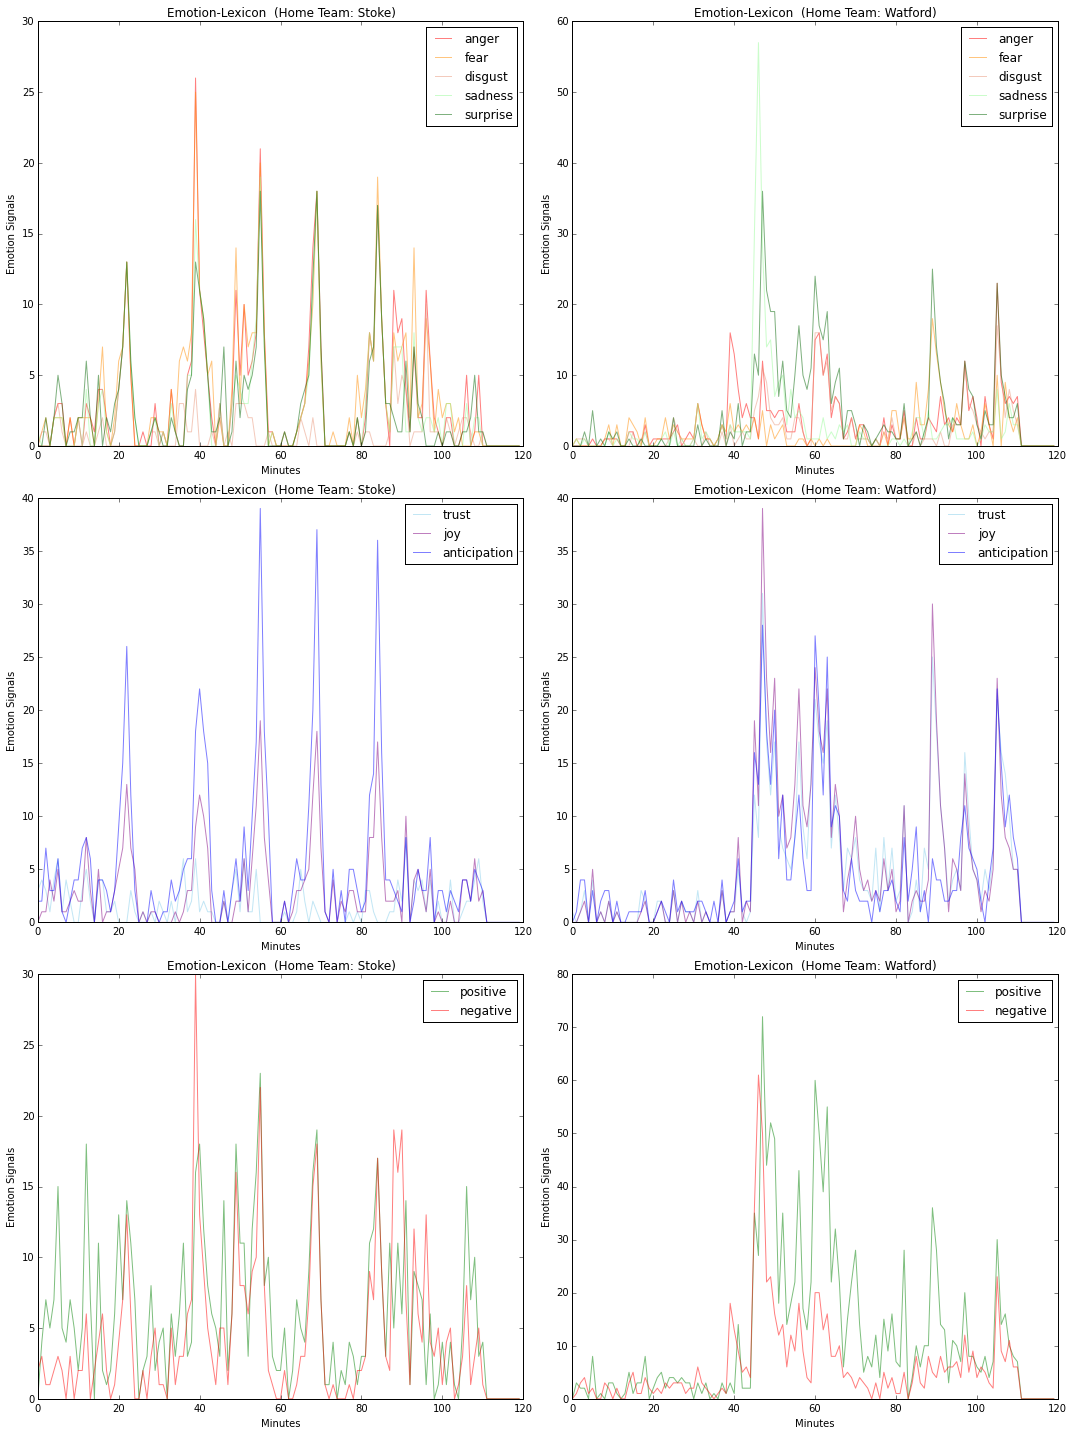


[Time]: 22.613519191741943

[Game]: Stoke vs Watford

0-1	DEENEY TROY(43)
0-2	ABDI ALMEN(69)




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 186 (0.07) 	 629 (0.17)
---------------------------------------------------
anticipation 		 656 (0.23) 	 570 (0.15)
---------------------------------------------------
     sadness 		 329 (0.12) 	 340 (0.09)
---------------------------------------------------
    surprise 		 331 (0.12) 	 561 (0.15)
---------------------------------------------------
        fear 		 432 (0.15) 	 252 (0.07)
---------------------------------------------------
         joy 		 370 (0.13) 	 668 (0.18)
---------------------------------------------------
       anger 		 396 (0.14) 	 389 (0.11)
---------------------------------------------------
     disgust 		 99 (0.04) 	 285 (0.08)



******[Sentiment]******
---------------------------

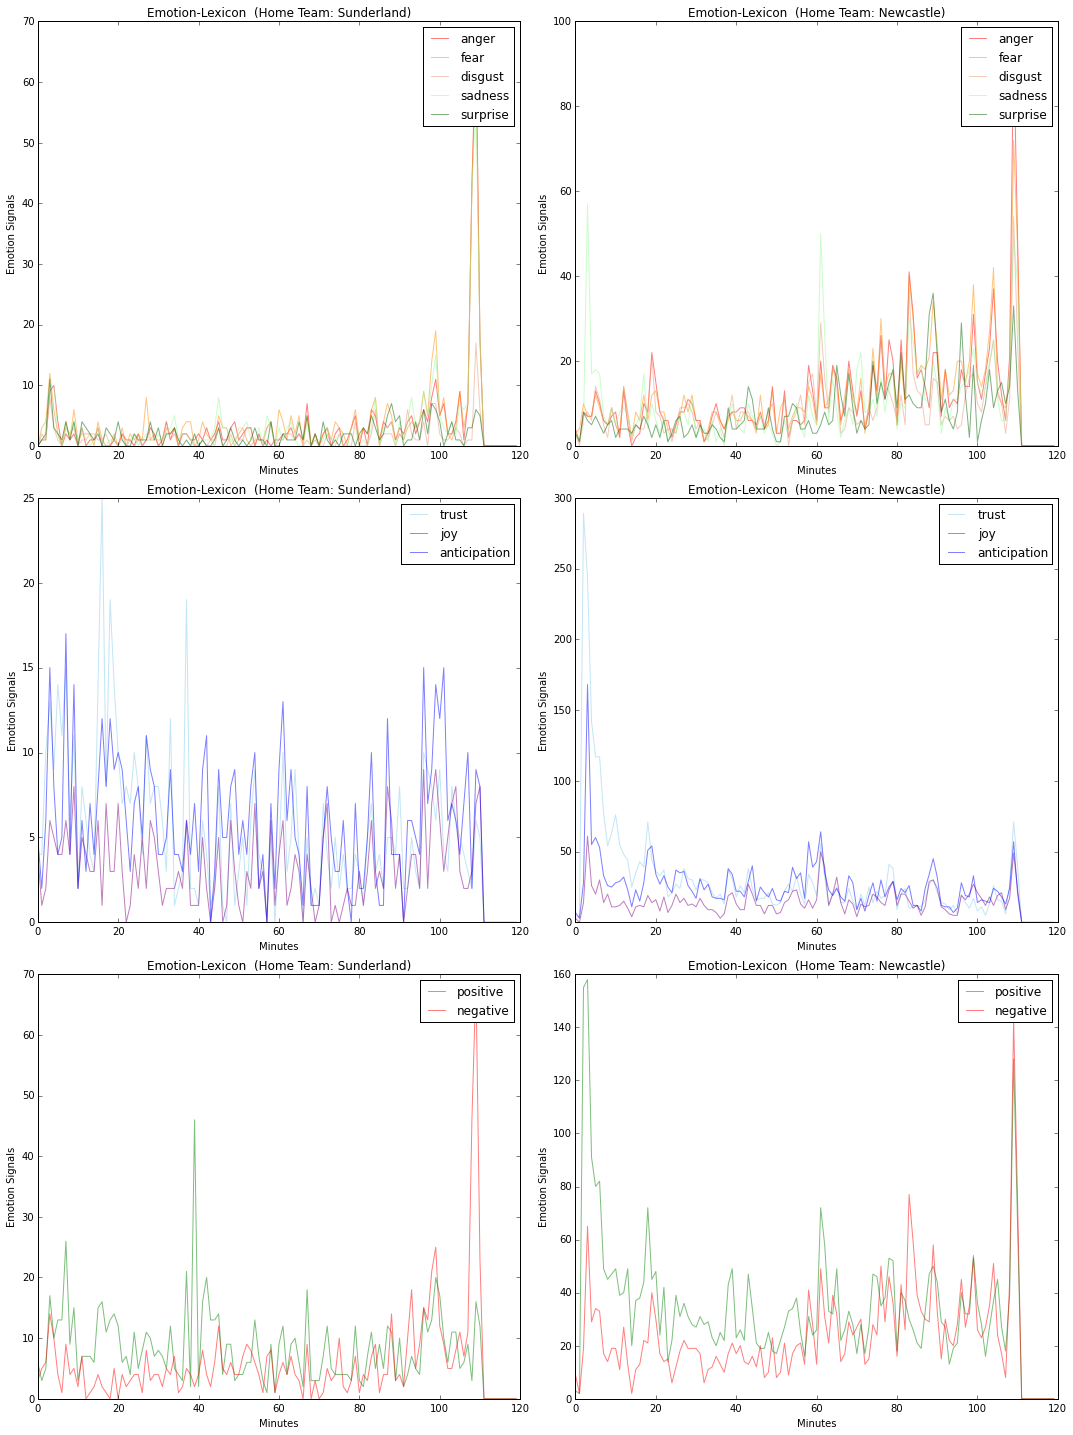


[Time]: 63.52006411552429

[Game]: Sunderland vs Newcastle

1-0	(Pen45+3)JOHNSON ADAM
2-0	(65)JONES BILLY
3-0	(86)FLETCHER STEVEN




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 648 (0.19) 	 3610 (0.25)
---------------------------------------------------
anticipation 		 698 (0.21) 	 3008 (0.21)
---------------------------------------------------
     sadness 		 392 (0.12) 	 1187 (0.08)
---------------------------------------------------
    surprise 		 223 (0.07) 	 926 (0.06)
---------------------------------------------------
        fear 		 456 (0.14) 	 1427 (0.10)
---------------------------------------------------
         joy 		 375 (0.11) 	 1771 (0.12)
---------------------------------------------------
       anger 		 388 (0.12) 	 1380 (0.10)
---------------------------------------------------
     disgust 		 180 (0.05) 	 1055 (0.07)



******

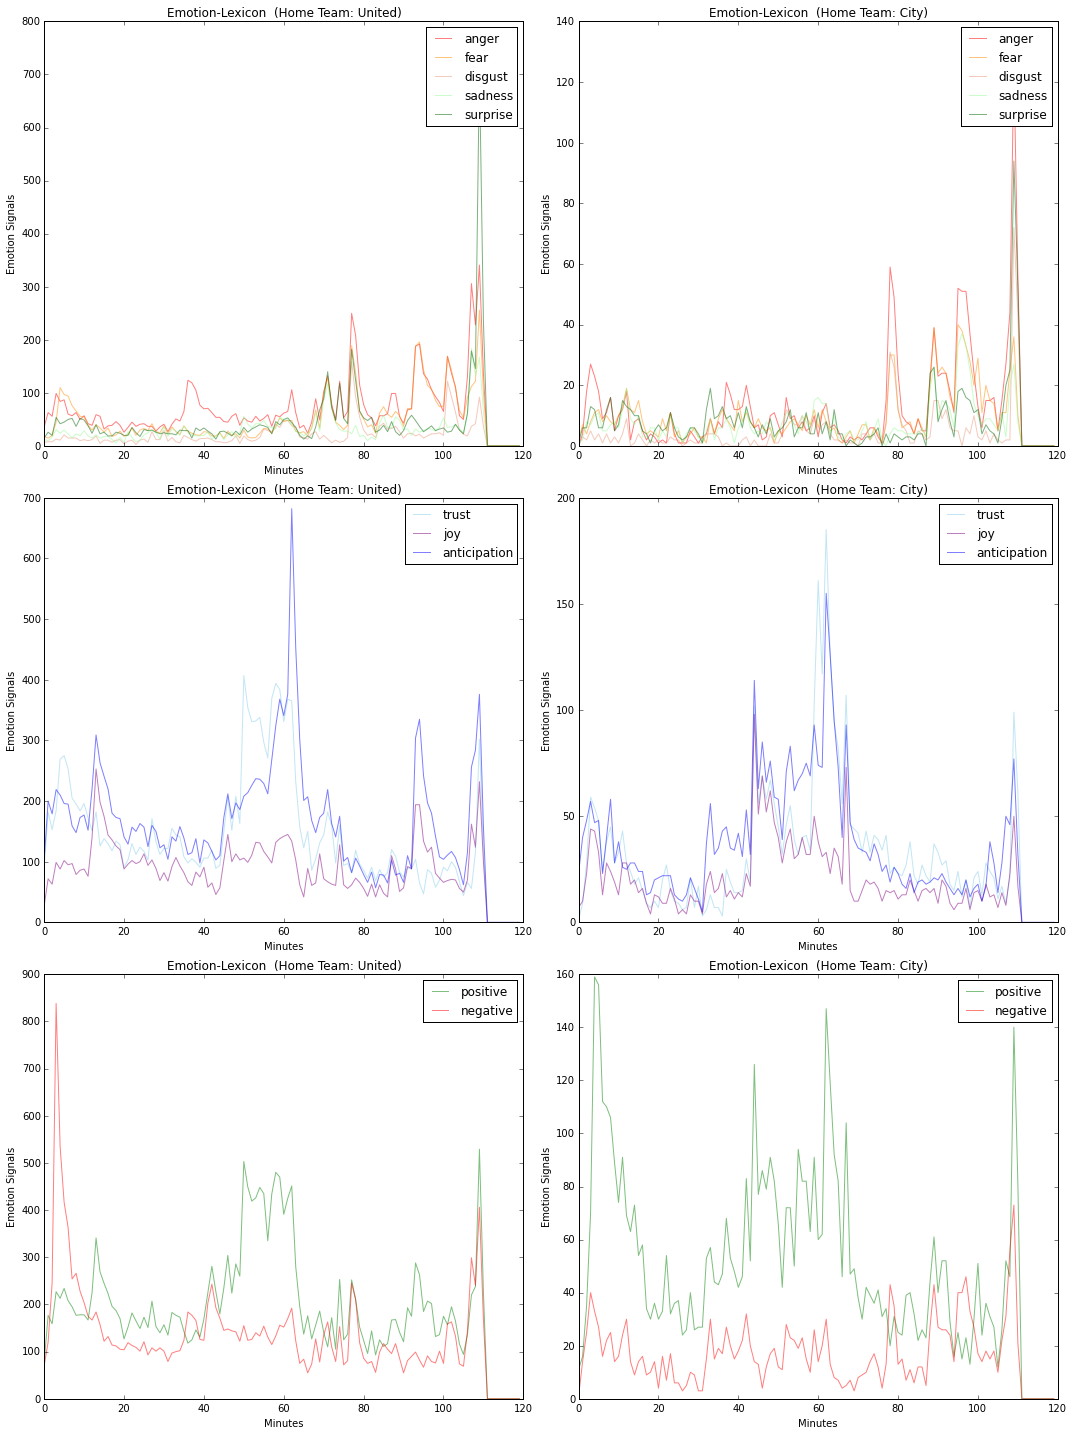


[Time]: 431.78765201568604

[Game]: United vs City

0-0
0-0




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 17060 (0.23) 	 3950 (0.25)
---------------------------------------------------
anticipation 		 19713 (0.27) 	 4345 (0.28)
---------------------------------------------------
     sadness 		 3826 (0.05) 	 910 (0.06)
---------------------------------------------------
    surprise 		 5437 (0.07) 	 963 (0.06)
---------------------------------------------------
        fear 		 6221 (0.08) 	 1160 (0.07)
---------------------------------------------------
         joy 		 10732 (0.14) 	 2393 (0.15)
---------------------------------------------------
       anger 		 8622 (0.12) 	 1503 (0.10)
---------------------------------------------------
     disgust 		 2617 (0.04) 	 548 (0.03)



******[Sentiment]******
-------------------------------------------

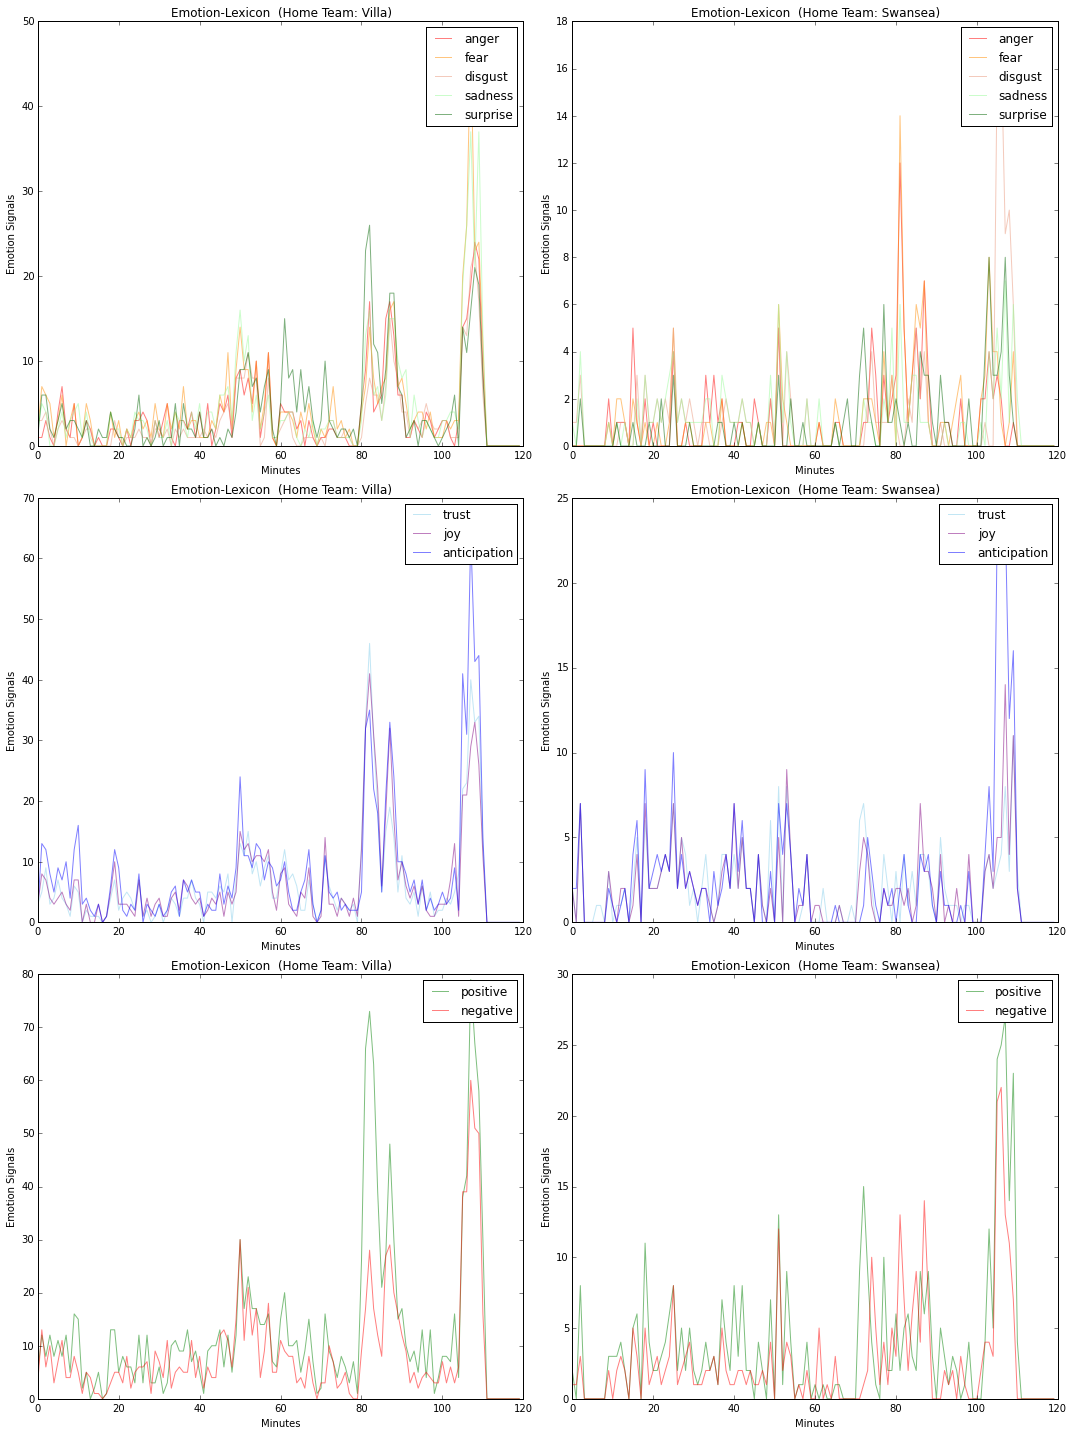


[Time]: 27.76005506515503

[Game]: Villa vs Swansea

0-0	No Scores
1-0	(62)AYEW JORDAN
1-1	SIGURDSSON GYLFI(68)
1-2	AYEW ANDRE(87)




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 793 (0.16) 	 243 (0.17)
---------------------------------------------------
anticipation 		 980 (0.20) 	 313 (0.22)
---------------------------------------------------
     sadness 		 539 (0.11) 	 137 (0.09)
---------------------------------------------------
    surprise 		 516 (0.10) 	 102 (0.07)
---------------------------------------------------
        fear 		 559 (0.11) 	 137 (0.09)
---------------------------------------------------
         joy 		 794 (0.16) 	 235 (0.16)
---------------------------------------------------
       anger 		 442 (0.09) 	 124 (0.09)
---------------------------------------------------
     disgust 		 366 (0.07) 	 155 (0.11)



******[Senti

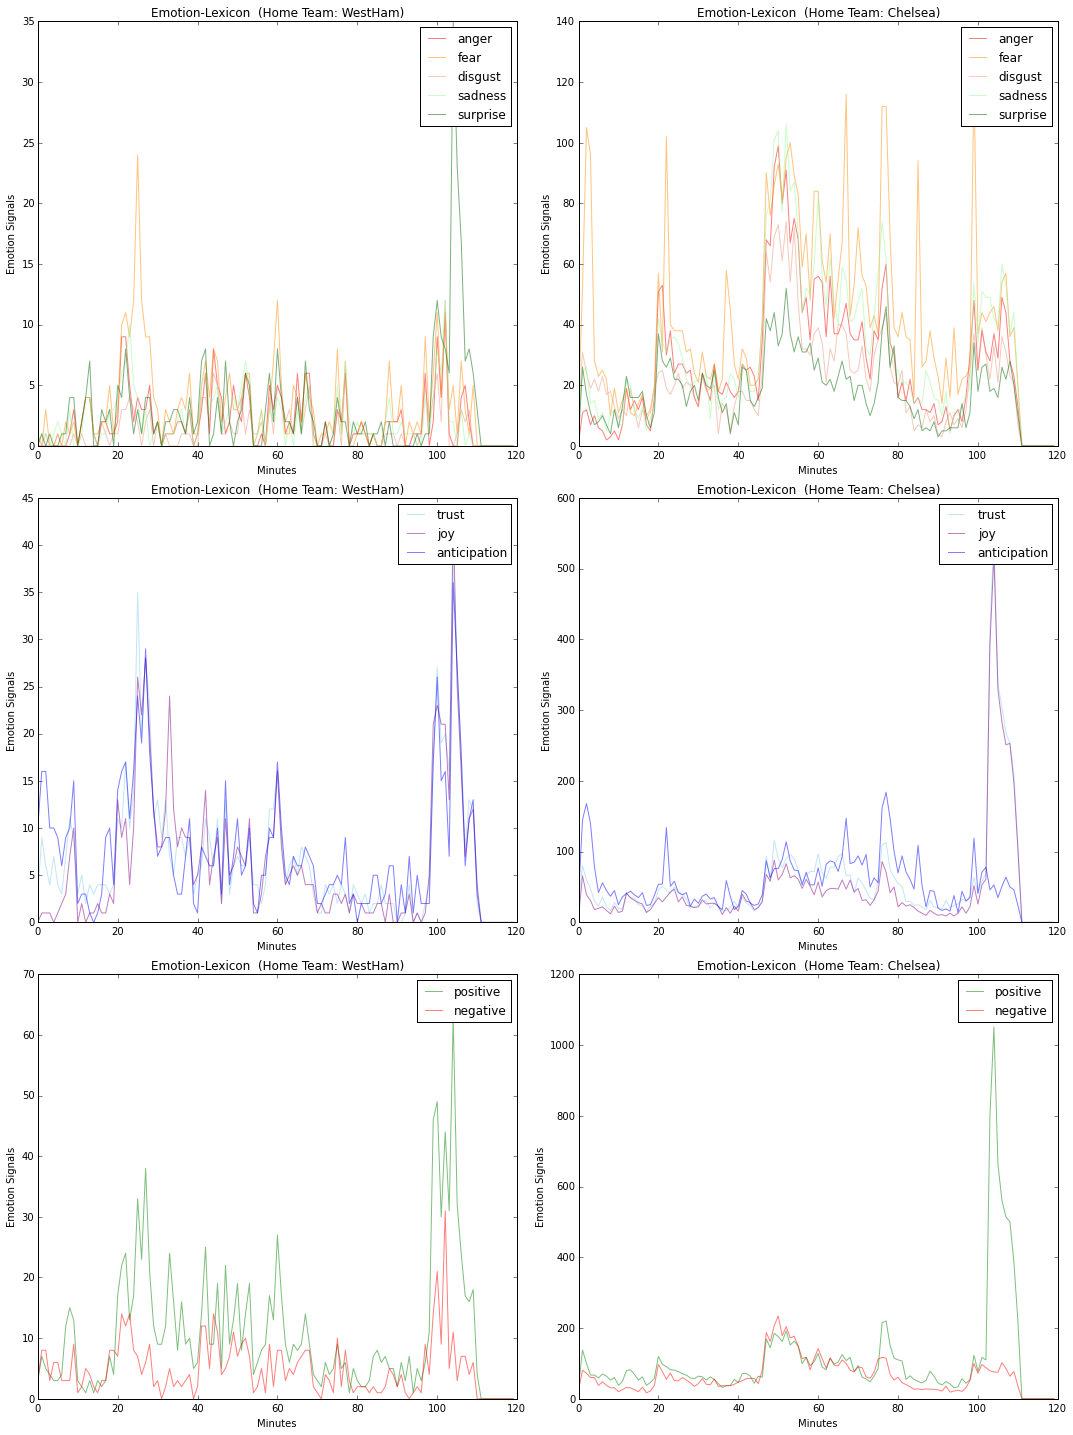


[Time]: 174.0010998249054

[Game]: WestHam vs Chelsea

1-0	(17)ZARATE MAURO
1-1	CAHILL GARY(56)
2-1	(79)CARROLL ANDY




******[Emotions]******
---------------------------------------------------
    CATEGORY 		 HOME TEAM 	 AWAY TEAM
---------------------------------------------------
       trust 		 861 (0.22) 	 7226 (0.20)
---------------------------------------------------
anticipation 		 891 (0.23) 	 6731 (0.18)
---------------------------------------------------
     sadness 		 249 (0.06) 	 3795 (0.10)
---------------------------------------------------
    surprise 		 355 (0.09) 	 2160 (0.06)
---------------------------------------------------
        fear 		 406 (0.10) 	 5018 (0.14)
---------------------------------------------------
         joy 		 763 (0.19) 	 5934 (0.16)
---------------------------------------------------
       anger 		 251 (0.06) 	 3245 (0.09)
---------------------------------------------------
     disgust 		 172 (0.04) 	 2653 (0.07)



******[Sentiment]*

In [9]:
# choosing data
os.chdir('/Users/Bya/Dropbox/Research/datas/Results/NB_Short_Long/')
filenames = GetFilenames('GW' + str(10))

game_key = 1
for filename in filenames:
#     filename = filenames[2]
    home_team = filename.split("_")[0][5::]
    away_team = filename.split("_")[2][0:-4]
    
    start = time.time()

    # create df
    df = create_emolex_df(filename)

    # plots
    plot_three(df, home_team, away_team)

    # time
    print("\n[Time]: %s" % (time.time() - start))

    # games
    print("================================")
    print("\n[Game]: %s vs %s" % (home_team, away_team))

    # goals and minutes
    print(dic_results_10[game_key])
    game_key += 1

    # calculated dics
    dic_home, dic_sent_home = calculate_df_emolex(df, 'home')
    dic_away, dic_sent_away = calculate_df_emolex(df, 'away')

    print("\n\n\n******[Emotions]******")
    print("---------------------------------------------------")
    print("    CATEGORY \t\t HOME TEAM \t AWAY TEAM")
    for key in dic_home.keys():
        print("---------------------------------------------------")
        print("%12s \t\t %.0f (%.2f) \t %.0f (%.2f)" % (key, dic_home[key][0], dic_home[key][1], 
                                     dic_away[key][0], dic_away[key][1]))

    print("\n\n\n******[Sentiment]******")
    print("---------------------------------------------------")
    print("    CATEGORY \t\t HOME TEAM \t AWAY TEAM")
    for key in dic_sent_home.keys():
        print("---------------------------------------------------")
        print("%12s \t\t %.0f (%.2f) \t %.0f (%.2f)" % (key, dic_sent_home[key][0], dic_sent_home[key][1], 
                                     dic_sent_away[key][0], dic_sent_away[key][1]))